#### Libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
import numpy as np
from numpy import expand_dims
import argparse
import os
import glob
import xmltodict
import xml.etree.ElementTree as ET
import xml.etree.ElementTree as ET # copy of xml
from xml.etree.ElementTree import parse
import cv2
from skimage import io
from scipy.signal import convolve2d
from PIL import Image  
import PIL 
import urllib
from urllib.request import urlopen
from typing import Tuple, List, Dict
from bs4 import BeautifulSoup
import requests
from io import BytesIO
from keras.applications import MobileNetV2
from keras import layers
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras import models
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing.image import array_to_img
# from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator # load the image
from keras.utils.image_utils import load_img
from keras.utils.image_utils import img_to_array
from keras.utils import to_categorical
from keras import backend as K
import pandas as pd

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import seaborn as sns 

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Load and transform images

#### Creation of URLs for images and annotations

In [4]:
prefix_url_imgs = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/images/"
number_of_imgs = 766 # +1 to include last one (765)

list_imgs = []

for i in range(0, number_of_imgs):
    i = str(i)
    var_imgs = "BikesHelmets" + i + ".png"
    var_imgs_url = prefix_url_imgs + var_imgs
    list_imgs.append(var_imgs_url)

#for i in range(0, len(list_imgs)):
#    response = requests.get(list_imgs[i])
#    img = Image.open(BytesIO(response.content))
#    plt.imshow(img)

In [5]:
prefix_url_xml = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/annotations/"
number_of_annt = 766 # +1 to include last one (765)

list_annotations= []

for i in range(0, number_of_annt):
    i = str(i)
    var_annt = "BikesHelmets" + i + ".xml"
    var_annt_url = prefix_url_xml + var_annt
    list_annotations.append(var_annt_url)

### Augmentantion functions

In [6]:
def picture_zoom(image):
   # to array
   array = expand_dims(image[1], 0)
   # create image data augmentation generator
   datagen_zoom= ImageDataGenerator(zoom_range=[0.8,1.5])
   # prepare iterator
   it_zoom = datagen_zoom.flow(array, batch_size=1)
   # generate batch of images
   batch_zoom = it_zoom.next()
   # convert to unsigned integers for viewing
   image_zoom = batch_zoom[0].astype('uint64')
   # returning list
   list = [image[0], image_zoom, image[2], image[3]]
   return list

In [7]:
def picture_rotation(image):
    # to array
    array = expand_dims(image[1], 0)
    # ImageDataGenerator rotation
    datagen_rotation=ImageDataGenerator(rotation_range=45, fill_mode='nearest')
    # prepare iterator
    it_rotation = datagen_rotation.flow(array, batch_size=1)
    # generate batch of images
    batch_rotation = it_rotation.next()
    # convert to unsigned integers for viewing
    image_rotation = batch_rotation[0].astype('uint64')
    # plot raw pixel 
    img_rotation=plt.imshow(image_rotation, interpolation ='None', filternorm=True) #spline36, antialiased
    # returning list
    list = [image[0], image_rotation, image[2], image[3]]
    return list

In [8]:
def picture_brightness(image):
    # to array
    array = expand_dims(image[1], 0)
    # create image data augmentation generator
    datagen_brightness = ImageDataGenerator(brightness_range=[0.2,1.0])
    # prepare iterator
    it_brightness = datagen_brightness.flow(array, batch_size=1)
    # generate batch of images
    batch_zoom = it_brightness.next()
    # convert to unsigned integers for viewing
    image_brightness = batch_zoom[0].astype('uint64')
    # plot raw pixel 
    img_brightness=plt.imshow(image_brightness, interpolation ='None')
    # returning list
    list = [image[0], image_brightness, image[2], image[3]]
    return list

### Retrieving and labelling images from XML annotations

#### Full images
* no bounding box, multiple faces per image
* for images with multiple people, if and only if all people wear helmet the label would be 1, otherwise label would be 0.

In [9]:
full_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            a = 0
            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            resized = img_temp.resize((224,224)) # resize all images to 224x224
            image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
            
            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        if i['name'] == 'With Helmet':
                            a =+1
                        else:
                            a =+0
                    if a > 0 :
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else :
                        full_imgs.append([tags['filename'], image, 0, img_path])
                
                if isinstance(tags['object'], dict):
                    if tags['object']['name'] == 'With Helmet':
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else:
                        full_imgs.append([tags['filename'], image, 0, img_path])
            else:
                pass
    except:
        pass

* Augment full images

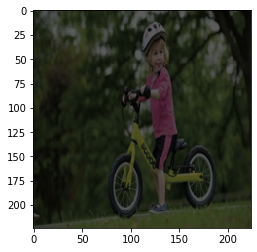

In [10]:
# Augmentantion of full images
augm_full_imgs = []
for i in range(0, len(full_imgs)+1):
    try:
        augm_full_imgs.append(picture_zoom(full_imgs[i]))
        augm_full_imgs.append(picture_rotation(full_imgs[i]))
        augm_full_imgs.append(picture_brightness(full_imgs[i]))
    except:
        pass

In [11]:
# consolidate initial with augmented images in one list
final_full_imgs = full_imgs + augm_full_imgs

print("Total full images:", len(final_full_imgs))
print("of which initial images:", len(full_imgs))
print("of which augmented images:", len(augm_full_imgs))

Total full images: 3040
of which initial images: 760
of which augmented images: 2280


* Transform full images to model inputs

In [12]:
# Transforming images in a proper array for model input
full_imgs_array = []
for i in range(0, len(final_full_imgs)+1):
    try:
        full_imgs_array.append(np.array(final_full_imgs[i][1]))
    except:
        pass
full_imgs_array = np.array(full_imgs_array, dtype='int')

In [13]:
# shape of new array
full_imgs_array.shape

(3040, 224, 224, 3)

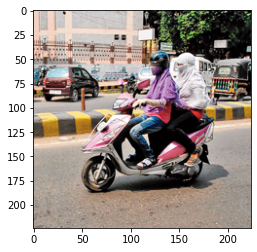

In [14]:
# testing that images appear correctly
plt.imshow(full_imgs_array[714])

In [349]:
#In Model2 does not need the reshape

# # reshape of array
# full_imgs_array_rshp = full_imgs_array.reshape(len(final_full_imgs), 224*224*3)

In [350]:
#In Model2 does not need the reshape

# # testing that images appear correctly
# plt.imshow(full_imgs_array_rshp[1500].reshape(224, 224, 3))

In [351]:
#In Model2 does not need the reshape

# # normalize colors
# full_imgs_array_final = full_imgs_array_rshp.astype('float32') / 255

In [352]:
#In Model2 does not need the reshape

# # final shape of input array
# full_imgs_array_final.shape

In [15]:
# Creating an array with labels
labels_array = []
for i in range(0, len(final_full_imgs)+1):
    try:
        labels_array.append(np.array(final_full_imgs[i][2]))
    except:
        pass
labels_array = np.array(labels_array, dtype='int')

In [16]:
# Categorically encode the labels
full_imgs_labels = to_categorical(labels_array)

#### Cropped images
* bounding box on heads, creation of multiple images per image

cropped_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            image = cv2.cvtColor(np.array(img_temp), cv2.INPAINT_TELEA)
            helmet = np.zeros(image.shape, dtype = 'int32')

            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        xmin = int(i['bndbox']['xmin'])
                        ymin = int(i['bndbox']['ymin'])
                        xmax = int(i['bndbox']['xmax'])
                        ymax = int(i['bndbox']['ymax'])
                        if i['name'] == 'With Helmet':
                            helmet = cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                            result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3) #with helmet -> 1
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path])
                            #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                            
                        else:
                            cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                            result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path]) #without helmet -> 0
                            
                            #plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                if isinstance(tags['object'], dict):
                    xmin = int(tags['object']['bndbox']['xmin'])
                    ymin = int(tags['object']['bndbox']['ymin'])
                    xmax = int(tags['object']['bndbox']['xmax'])
                    ymax = int(tags['object']['bndbox']['ymax'])
                    if tags['object']['name'] == 'With Helmet':
                        cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                        result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path]) #with helmet -> 1
                        #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                    else:
                        cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                        result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path]) #without helmet -> 0
                    # plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
            else:
                pass
    except:
        pass

* Augment cropped images
###### 
We will use data augmantation to artificially create more data samples.
This allows us to create new  images by manipulating the existing ones ( rotating and brightness).

# Augmentantion of cropped images
augm_cropped_imgs = []
for i in range(0, len(cropped_imgs)):
    try:
        #augm_cropped_imgs.append(picture_zoom(cropped_imgs[i]))
        augm_cropped_imgs.append(picture_rotation(cropped_imgs[i]))
        augm_cropped_imgs.append(picture_brightness(cropped_imgs[i]))
    except:
        pass

# consolidate initial cropped images with augmented in one list
all_cropped_imgs = cropped_imgs + augm_cropped_imgs

# checking average height and width of images
x = 0
y = 0
itt = len(all_cropped_imgs)
for i in range(0, len(all_cropped_imgs)+1):
    try:
        tmp_shape = all_cropped_imgs[i][1].shape
        x += tmp_shape[0]
        y += tmp_shape[1]
    except:
        itt -=1
        pass

print(round(x/itt,0))
print(round(y/itt,0))

# all images must have the same size
# as we cannot resize the images during the load of them because this maybe 
# would have a negative effect on bounding box coordinates, the resize is happening hear
all_cropped_imgs_v2 = []
for i in range(1, len(all_cropped_imgs)):
    try:
        img_temp =array_to_img(all_cropped_imgs[i][1])
        resized = img_temp.resize((40,40)) # resize all images to 40x40
        image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
        all_cropped_imgs_v2.append([all_cropped_imgs[i][0], image, all_cropped_imgs[i][2], all_cropped_imgs[i][3]])
    except:
        pass

plt.imshow(all_cropped_imgs_v2[4300][1], interpolation='nearest')

print("Total cropped images:", len(all_cropped_imgs_v2))
print("of which initial cropped images:", len(cropped_imgs))
print("of which augmented cropped images:", (len(all_cropped_imgs_v2)-len(cropped_imgs)))

* Transform cropped images to model inputs

# Transforming images in a proper array for model input
cropped_imgs_array = []
for i in range(0, len(all_cropped_imgs_v2)):
    cropped_imgs_array.append(np.array(all_cropped_imgs_v2[i][1]))
    
cropped_imgs_array = np.array(cropped_imgs_array, dtype='int')

# shape of new array
cropped_imgs_array.shape

# testing that images appear correctly
plt.imshow(cropped_imgs_array[1500])

# Creating an array with labels
labels_array_cropped = []
for i in range(0, len(all_cropped_imgs_v2)):
    labels_array_cropped.append(np.array(all_cropped_imgs_v2[i][2]))
    
labels_array_cropped = np.array(labels_array_cropped, dtype='int')


# Categorically encode the labels
cropped_imgs_labels = to_categorical(labels_array_cropped)

#### Model 2 -- Eftychia Gkini 2022/08/18

In [355]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

* Split imbalanced dataset into train and test sets with stratification


##### 
We now split the full data set into train (75%) and test (25%) sets. The test set is split again to test (25%) and validation (75%) sets.
#####
Random sampling is a very bad option for splitting. So, we try stratified sampling. 
This splits your class proportionally between training and test set. 
Run oversampling, undersampling or hybrid techniques on training set. 



In [63]:
#https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# split into train test sets
from sklearn.model_selection import train_test_split
X_train,X_test_1 , y_train, y_test_1 = train_test_split(full_imgs_array, full_imgs_labels,
                                                    stratify=full_imgs_labels, 
                                                    test_size=0.25, random_state=5)

X_test,X_val , y_test, y_val = train_test_split(X_test_1, y_test_1,
                                                    stratify=y_test_1, 
                                                    test_size=0.25, random_state=5)

### --------------------------------------------- MODEL 1 --------------------------------------------- 

* Model Building - CNN
#####
We are doing Detection Classsifier using CNN.


In [137]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (224, 224, 3))) #224, 224
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.4)) #model.add(Dropout(0.3))
model.add(Dense(units = 2, activation = 'softmax')) #Check if the last Dense Layer(output) has same number of classes as the number of target classes in the training dataset.
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 28, 28, 64)     

In [138]:
batch_size = 8 #The number of training examples utilized in one iteration.
epochs = 30

In [139]:
# Compiling the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    #metrics="accuracy"
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)
#model.optimizer.lr=0.001

* Early Stopping
###### 
Before training the network, we define an early stopping criterion, to avoid redundent epochs once the model has already converged.


In [140]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

* Reduce Learning Rate On Plateau
###### 
We define a ReduceLROnPlateau callback to reduce the learning rate when the metric we chose (val_loss) has stopped improving.

In [141]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

* Fit the model on train data


In [24]:
data_size = len(X_train) 
steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

# val_steps = int(len(val_generator) // batch_size)
# print(f"val_steps: {val_steps}")

steps_per_epoch: 285


In [195]:
# Fit the model on train data
model_history = model.fit(
    x=X_train,
    y=y_train,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2, #will just mention the number of epoch like this 
    # verbose=0 will show you nothing (silent)
    validation_data=(X_val,y_val),
    # validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

* Model Evaluation
###### Evaluation is a process during development of the model to check whether the model is best fit for the given problem and corresponding data. Keras model provides a function, evaluate which does the evaluation of the model. It has three main arguments,

In [ ]:
# Evaluate model performance on test data
model_loss, model_acc, recall, precision, auc = model.evaluate(X_train,y_train,verbose = 0)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))
print("Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (recall*100, precision*100, auc*100))

In [ ]:
# pred=model.predict(X_test) 
# pred = np.argmax(pred, axis = 1)[:] 
# label = np.argmax(y_test,axis = 1)[:] 

#second way
predictions = model.predict(X_test)
print("predictions shape:", predictions.shape)

In [ ]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

In [ ]:
plot_loss_and_accuracy(model_history.history)

In [25]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
#     precision = precision_score(y, y_hat)
#     recall = recall_score(y, y_hat)
#     accuracy = accuracy_score(y,y_hat)
#     f1 = f1_score(y,y_hat)
#     report = classification_report(y,y_hat)
#     print(report)
#     print('Recall: ', recall)
#     print('Accuracy: ', accuracy)
#     print('Precision: ', precision)
#     print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

* A clear idea of the actual and predicted values

18/18 [==============================] - 4s 230ms/step


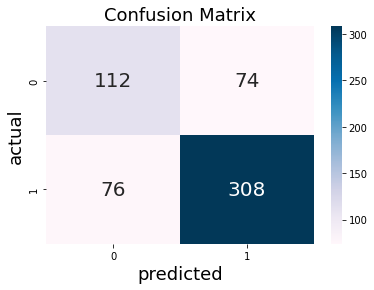

In [198]:
y_true = np.argmax(y_test,axis = 1)[:]
# y_true = y_test

pred = model.predict(X_test) # Predict prob and get Class Indices
y_pred= np.argmax(pred, axis = 1)[:]

evaluation(y_true, y_pred) #Confusion Matrix

* A general idea of the occurrences of each class

In [199]:
np.bincount(y_pred) # Use bincount() to count occurrences of each class in a predictions NumPy array

array([188, 382], dtype=int64)

### --------------------------------------------- MODEL 2 --------------------------------------------- 

###### Creating the mask detection deep learning model¶
###### We will now look into building a Deep Learning model to predict (detect) if a person is violating the rules by not wearing a mask in public spaces.

In [135]:
# keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [136]:
# Initializing the VGG19 model
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

# Initialize a sequential model
model_vgg19 = Sequential()
model_vgg19.add(vgg19_model)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(2, activation="sigmoid"))
model_vgg19.summary()

# Compiling the model
model_vgg19.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_19 (Flatten)        (None, 25088)             0         
                                                                 
 dense_38 (Dense)            (None, 2)                 50178     
                                                                 
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


##### Train the model
###### We will now train our neural network model for 20 epochs.

In [ ]:
model_history = model_vgg19.fit(
    x=X_train,
    y=y_train,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=(X_val,y_val),
    validation_steps=len(X_val) // 32,
    callbacks=[early_stopping, lrr]
)

#### Evaluate the model performance on test set

In [ ]:
model_vgg19_loss, model_vgg19_acc, model_vgg19_recall, model_vgg19_precision, model_vgg19_auc = model_vgg19.evaluate(X_train,y_train,verbose = 0)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_vgg19_loss, model_vgg19_acc*100))
print("Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (model_vgg19_recall*100, model_vgg19_precision*100, model_vgg19_auc*100))

18/18 [==============================] - 254s 14s/step


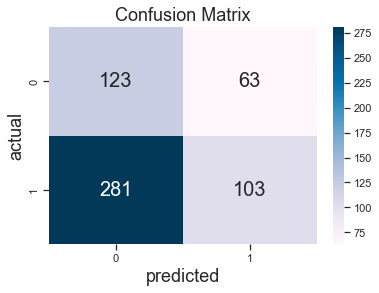

In [344]:
y_true = np.argmax(y_test,axis = 1)[:]
# y_true = y_test

pred = model_vgg19.predict(X_test) # Predict prob and get Class Indices
y_pred= np.argmax(pred, axis = 1)[:]

evaluation(y_true, y_pred)

### --------------------------------------------- MODEL 3 --------------------------------------------- 
###### https://www.kaggle.com/code/aman10kr/face-mask-detection-using-ssd

In [142]:
model_SSD = Sequential()
model_SSD.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(224, 224,3)))
model_SSD.add(Conv2D(64, (3, 3), activation='relu'))
model_SSD.add(Conv2D(128, (3, 3), activation='relu'))
model_SSD.add(MaxPooling2D(pool_size=(2,2)))
model_SSD.add(Dropout(0.25))
model_SSD.add(Flatten())
model_SSD.add(Dropout(0.5))
model_SSD.add(Dense(50, activation='relu'))
model_SSD.add(Dropout(0.5))
model_SSD.add(Dense(2, activation='sigmoid'))
# model_SSD.summary()

In [143]:
model_SSD.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

In [ ]:
history = model_SSD.fit(
            x=X_train,
            y=y_train,
            steps_per_epoch=5,#len(X_train) // 32,
            epochs=10,
            verbose=1,
            validation_data=(X_val,y_val),
            validation_steps=len(X_val) // 32,
            callbacks=[early_stopping, lrr]
            )

Epoch 1/10


: 

: 

In [ ]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_true = np.argmax(y_test,axis = 1)[:]
# y_true = y_test

pred = model_SSD.predict(X_test) # Predict prob and get Class Indices
y_pred= np.argmax(pred, axis = 1)[:]
evaluation(y_true, y_pred)

#### --------------------------------------------- Αχρηστο χαλια --------------------------------------------- 


* Model 5 -- Eftychia Gkini 2022/08/18
######
https://www.kaggle.com/code/ayushimishra2809/face-mask-detection

from keras.layers import LSTM

model2=Sequential()
model2.add(Conv2D(100,(3,3),input_shape=X_train.shape[1:],activation='relu',strides=2))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Flatten())
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.2)) # fropout is one way to regularize neural network and avoid overfitting
model2.add(Dense(2, activation='softmax'))

import tensorflow as tf

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision', 'AUC']) 

model2.fit( x=X_train,
            y=y_train,
            epochs=8, #30,
            steps_per_epoch=50, #len(X_train) // 32
            batch_size=5,
            verbose=1,
            callbacks=[early_stopping, lrr])

model2_loss, model2_acc, model2_recall, model2_precision, model2_auc = model2.evaluate(X_train,y_train,verbose = 0)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model2_loss, model2_acc*100))
print("Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (model2_recall*100, model2_precision*100, model2_auc*100))

y_true = np.argmax(y_test,axis = 1)[:]
# y_true = y_test

pred = model2.predict(X_test) # Predict prob and get Class Indices
y_pred= np.argmax(pred, axis = 1)[:]
evaluation(y_true, y_pred)

### --------------------------------------------- MODEL 4 --------------------------------------------- 
###### https://github.com/mohandandamudi/FaceMaskDetection/blob/master/Face%20Mask%20Detection.ipynb

In [144]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.models import Sequential
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

* Buliding Initial Model 

In [126]:
# split into train test sets
from sklearn.model_selection import train_test_split
X_train,X_test_1 , y_train, y_test_1 = train_test_split(full_imgs_array, full_imgs_labels,
                                                    stratify=full_imgs_labels, 
                                                    test_size=0.25, random_state=5)

X_test,X_val , y_test, y_val = train_test_split(X_test_1, y_test_1,
                                                    stratify=y_test_1, 
                                                    test_size=0.25, random_state=5)

In [145]:
model_few_Layers = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(learning_rate=0.001)
model_few_Layers.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
model_few_Layers.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 394272)            0         
                                                                 
 dense_43 (Dense)            (None, 2)                 788546    
                                                                 
Total params: 789,442
Trainable params: 789,442
Non-trainable params: 0
_________________________________________________________________


In [128]:
history = model_few_Layers.fit(
                    x=X_train,
                    y=y_train,
                    epochs=30, #30,
                    steps_per_epoch=100, #len(X_train) // 32
                    batch_size=5,
                    verbose=1,
                    callbacks=[early_stopping, lrr],
                    validation_data=(X_val,y_val)
                    # ,callbacks=[checkpoint]
                    )

Epoch 1/30
100/100 [==============================] - 21s 185ms/step - loss: 582.3679 - acc: 0.5800 - val_loss: 7.1448 - val_acc: 0.5632 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 17s 167ms/step - loss: 5.6025 - acc: 0.6440 - val_loss: 4.0875 - val_acc: 0.6263 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 16s 158ms/step - loss: 4.5216 - acc: 0.6680 - val_loss: 3.2972 - val_acc: 0.6895 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 16s 163ms/step - loss: 2.8891 - acc: 0.7260 - val_loss: 2.5335 - val_acc: 0.7632 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 16s 162ms/step - loss: 1.7834 - acc: 0.7920 - val_loss: 2.7911 - val_acc: 0.7684 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 13s 134ms/step - loss: 0.6118 - acc: 0.9260 - val_loss: 1.7785 - val_acc: 0.7474 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 21s 209ms/step - loss: 1.3208 - acc: 0.9240 - val_loss: 

In [ ]:
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
# checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

18/18 [==============================] - 5s 287ms/step


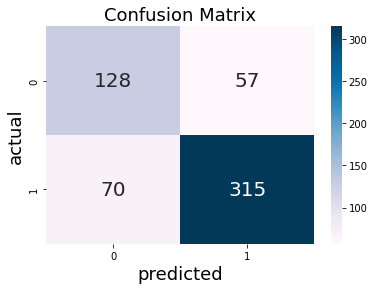

In [129]:
y_true = np.argmax(y_test,axis = 1)[:]
# y_true = y_test 

pred = model_few_Layers.predict(X_test) # Predict prob and get Class Indices
y_pred= np.argmax(pred, axis = 1)[:]

evaluation(y_true, y_pred)

* Plotting the model accuracy and loss

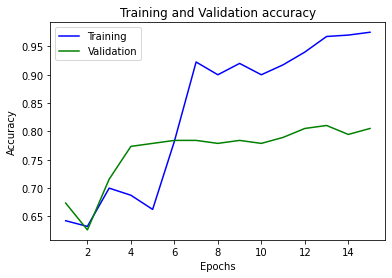

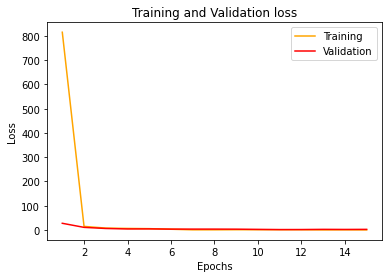

In [123]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)

# plotting accuracy 

plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### --------------------------------------------- MODEL 5 --------------------------------------------- 
###### Αποτελέι συνέχεια του προηγούμενου μοντέλου

* Creating Improved model
#####
We are going to use VGG16 model here

In [146]:
vgg16_model=tf.keras.applications.vgg16.VGG16()
# vgg16_model.summary() #lets look at summary.

In [147]:
# Checking the type of model
type(vgg16_model)

keras.engine.functional.Functional

* Couple of things that need to be changes.
1. We need a sequential model unlike VGG16
2. The last Dense layer in VGG16 has 1000 ouputs but we need only two

In [148]:
# So we will create a blank sequential model and then add layers from VGG16 except last one
improved_model =tf.keras.models.Sequential()

for layer in vgg16_model.layers[:-1]:
    improved_model.add(layer)

improved_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)     

In [149]:
# By Default the VGG16 layers are well trained for image classification so no need to update the weights at each layer.
for layer in improved_model.layers:
    layer.trainable=False

In [150]:
# Adding dense layer with 2 outputs
improved_model.add(tf.keras.layers.Dense(2, activation='softmax'))

opt = optimizers.Adam(learning_rate=0.001)
improved_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc']) 

#Lets look at the final model summary.
improved_model.summary()

In [45]:
history2 = improved_model.fit(x=X_train,
                            y=y_train,
                            epochs=5, #30,
                            steps_per_epoch=10, #len(X_train) // 32
                            batch_size=5,
                            verbose=1,
                            validation_data=(X_val,y_val),
                            callbacks=[early_stopping, lrr],
                            #  ,callbacks=[checkpoint]
                            )

Epoch 1/5
10/10 [==============================] - 112s 12s/step - loss: 0.3078 - acc: 0.8800 - val_loss: 0.5249 - val_acc: 0.8000 - lr: 0.0010
Epoch 2/5
10/10 [==============================] - 110s 12s/step - loss: 0.3480 - acc: 0.8800 - val_loss: 0.5101 - val_acc: 0.8053 - lr: 0.0010
Epoch 3/5
10/10 [==============================] - 118s 13s/step - loss: 0.3068 - acc: 0.9200 - val_loss: 0.5890 - val_acc: 0.7842 - lr: 0.0010
Epoch 4/5
10/10 [==============================] - 116s 13s/step - loss: 0.3960 - acc: 0.8200 - val_loss: 0.4997 - val_acc: 0.8053 - lr: 0.0010
Epoch 5/5
10/10 [==============================] - 94s 10s/step - loss: 0.2707 - acc: 0.9400 - val_loss: 0.4972 - val_acc: 0.8368 - lr: 0.0010


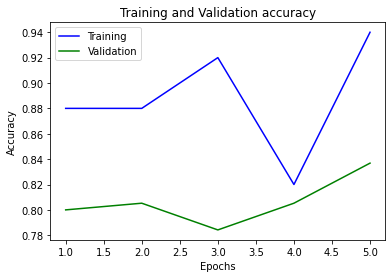

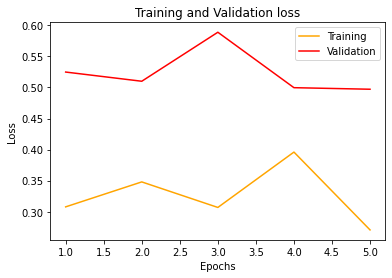

In [46]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
acc = history2.history['acc']
val_acc = history2.history['val_acc']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### --------------------------------------------- MODEL 6 --------------------------------------------- 
#####
https://github.com/hrithikppawar/Face-Mask-Detection-Using-VGG16/blob/main/Face_Mask_Detection_VGG16.ipynb

In [151]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [86]:
# Important variables 
INPUT_SIZE = [224, 224]
BATCH = 32

In [152]:
vgg16 = VGG16(input_shape=INPUT_SIZE + [3], weights='imagenet', include_top=False)

In [153]:
for layer in vgg16.layers:
    layer.trainable = False
# vgg16.summary()

In [154]:
flatten = Flatten()(vgg16.output)
dense_1 = Dense(units=500, activation='relu')(flatten)
dense_2 = Dense(units=500, activation='relu')(dense_1)
dense_3 = Dense(units=100, activation='relu')(dense_2)
dense_4 = Dense(units=100, activation='relu')(dense_3)
dense_output = Dense(units=2, activation='sigmoid')(dense_4)

In [155]:
model_NEW = Model(inputs=vgg16.input, outputs=dense_output)
# model_NEW.summary()

In [156]:
model_NEW.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [100]:
history2 = model_NEW.fit(x=X_train,
                            y=y_train,
                            epochs=5, #epochs=60,
                            steps_per_epoch=10, #len(X_train) // 32
                            batch_size=5,
                            verbose=1,
                            validation_data=(X_val,y_val),
                            callbacks=[early_stopping, lrr],
                            #  ,callbacks=[checkpoint]
                            )

Epoch 1/5
10/10 [==============================] - 163s 17s/step - loss: 9.6026 - accuracy: 0.6400 - val_loss: 4.8404 - val_accuracy: 0.6368 - lr: 0.0010
Epoch 2/5
10/10 [==============================] - 123s 13s/step - loss: 4.6287 - accuracy: 0.7200 - val_loss: 2.8298 - val_accuracy: 0.5684 - lr: 0.0010
Epoch 3/5
10/10 [==============================] - 102s 11s/step - loss: 3.7535 - accuracy: 0.4000 - val_loss: 2.4103 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 4/5
10/10 [==============================] - 126s 14s/step - loss: 2.2691 - accuracy: 0.5800 - val_loss: 2.7322 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 5/5
10/10 [==============================] - 102s 11s/step - loss: 3.4503 - accuracy: 0.6600 - val_loss: 1.7349 - val_accuracy: 0.6526 - lr: 0.0010


### --------------------------------------------- Comparison --------------------------------------------- 


Compare Machine Learning Models Carefully
#####
When you have a new dataset, it is a good idea to visualize the data using different techniques in order to look at the data from different perspectives.

In [130]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss
from sklearn.datasets import make_classification
from sklearn import model_selection

* Precision: The model precision score measures the proportion of positively predicted labels that are actually correct. Precision is also known as the positive predictive value. Precision Score = TP / (FP + TP)
* Accuracy: Tells us how often we can expect our machine learning model will correctly predict an outcome out of the total number of times it made predictions.  Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)
* Recall score is used to measure the model performance in terms of measuring the count of true positives in a correct manner out of all the actual positive values.
* F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively. 
    F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)



In [160]:
classifiers = [
    # model,
    # model_vgg19,
    # model_SSD,
    # model_few_Layers,
    # vgg16_model,
    improved_model,
    model_NEW
    ]
name_of_model = [
    # "model",
    # "model_vgg19",
    # "model_SSD",
    # "model_few_Layers",
    # "vgg16_model"
    # "improved_model",
    "model_NEW"
  
    ]
    

In [164]:
# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Precision", "Recall", "F1", "AUC"]

log = pd.DataFrame(columns=log_cols)
i=0

for clf in classifiers:

    name=name_of_model[i]
    i+=1    

    #Fit the model
    # clf.fit(x=X_train,
    #                         y=y_train,
    #                         epochs=5, #epochs=60,
    #                         steps_per_epoch=10, #len(X_train) // 32
    #                         batch_size=5,
    #                         verbose=0 ,  # Verbosity mode. 0 = silent
    #                         validation_data=(X_val,y_val),
    #                         callbacks=[early_stopping, lrr],
    #                         #  ,callbacks=[checkpoint]
    #                         )

    # calculate y_pred
    y_true = np.argmax(y_test, axis = 1)[:]
    pred = clf.predict(X_test,verbose = 0) # Predict prob and get Class Indices
    y_pred= np.argmax(pred, axis = 1)[:]

    # calcualte accuracy
    acc=accuracy_score(y_pred[:],y_true[:])
    
    # calcualte precision	
    pre=precision_score(y_pred[:],y_true[:])

    # calcualte Recall	
    rec=recall_score(y_pred[:],y_true[:])

    # calcualte F1-score
    f1= f1_score(y_pred[:],y_true[:])

    ## calculate scores
    auc = roc_auc_score(y_true, y_pred)
    
    #entry them in a dataframe for visualization
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100, f1*100, auc*100]], columns=log_cols)
    log = log.append(log_entry)
    
    # Print the results
    # print("="*30)   
    # print('**** Results ' + name + '****')
    # print("Accuracy: {:.4%}".format(acc))
    # print("Precision: {:.4%}".format(pre) )
    # print("Recall: {:.4%}".format(rec) )
    # print("F1-score: {:.4%}".format(f1) )
    # print( name + ": ROC AUC: {:.4%}".format(auc))

# print("="*15 + " End " + "="*15)

In [159]:
log

,Classifier,Accuracy,Precision,Recall,F1,AUC
0,model,56.666667,64.675325,69.166667,66.845638,52.337662
0,model_vgg19,54.210526,57.922078,69.254658,63.083451,52.204282
0,model_SSD,65.087719,93.766234,67.350746,78.393051,49.585820
0,model_few_Layers,67.543860,100.000000,67.543860,80.628272,50.000000


* Plot

In [ ]:
######################################## Accuracy ###########################################################
# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(b = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)


sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.2,
             str(round((i.get_width()), 2)),
             fontsize = 8, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

############################################# Precision ###########################################################

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(b = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log, color="g")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.2,
             str(round((i.get_width()), 2)),
             fontsize = 8, fontweight ='bold',
             color ='dimgrey')


plt.xlabel('Precision %')
plt.title('Classifier Precision')
plt.show()

############################################# Recall ###########################################################

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(b = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color='c')

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y(),
             str(round((i.get_width()), 2)),
             fontsize = 8, fontweight ='bold',
             color ='dimgrey')


plt.xlabel('Recall %')
plt.title('Classifier Recall')
plt.show()

############################################# F1 ###########################################################

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(b = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='F1', y='Classifier', data=log, color="y")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.2,
             str(round((i.get_width()), 2)),
             fontsize = 8, fontweight ='bold',
             color ='dimgrey')


plt.xlabel('F1-score %')
plt.title('Classifier F1-score')
plt.show()

############################################# AUC ###########################################################
# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(b = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='AUC', y='Classifier', data=log, color="r")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.2,
             str(round((i.get_width()), 2)),
             fontsize = 8, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Area Under Curve')
plt.title('Classifier AUC')
plt.show()

c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


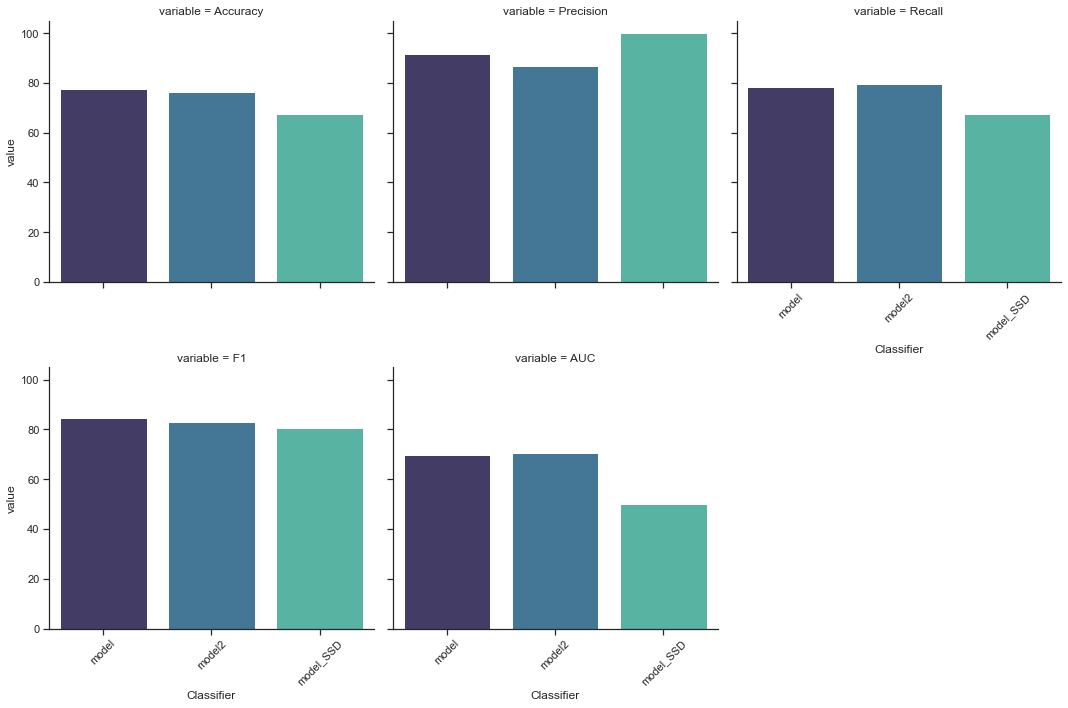

In [ ]:

#ΔΕΝ ΜΠΟΡΩ ΝΑ ΒΑΛΨ ΤΙΣ ΑΤΟΜΙΚΕΣ ΤΙΜΕΣ ΑΝΑ column
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

df2 = pd.melt(log, value_vars=[ "Accuracy", "Precision", "Recall", "F1", "AUC"], id_vars="Classifier")

sns.set(style="ticks")

g = sns.factorplot(data=df2,
                   kind="bar",
                   col="variable", # we have 1 plot per variable, forming 1 line and 5 columns (5 different variables)
                   x="Classifier", # in each plot the x-axis will be the name
                   y="value", # the height of the bar
                   col_wrap=3,# we actually want your line of plots to contain 3 plots maximum 
                   palette="mako", #Set2,Paired
                  ) 
g.set_xticklabels(rotation=45) # rotate the labels so they don't overlap
plt.tight_layout() # fit everything into the figure



* Plot Area Under Curve

C:\Users\Eftixia\AppData\Local\Temp\ipykernel_17644\588644489.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True, color ='dimgrey',


KeyboardInterrupt: 

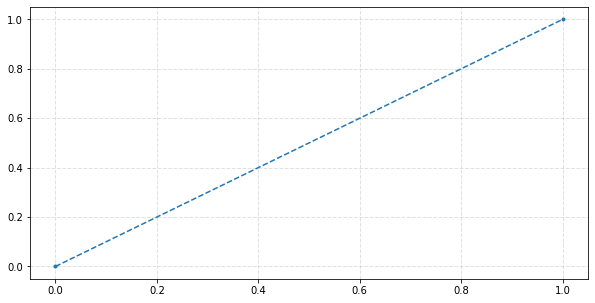

In [131]:
i=0
labels=[]

# Figure Size
plt.subplots(figsize =(10, 5))


# Add x, y gridlines
plt.grid(b = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

# Plot several different AUC
for clf in classifiers:

  name=name_of_model[i]
   
  i+=1    
 
  y_true = np.argmax(y_test, axis = 1)[:]

  pred = clf.predict(X_test,verbose = 0) # Predict prob and get Class Indices
  y_pred= np.argmax(pred, axis = 1)[:]

   # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_true, y_pred)

   # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, marker='.', linestyle='--', label=name)
  labels.append(name)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(labels, 
          columnspacing=1.0, 
          labelspacing=0.0,
          handletextpad=0.0, 
          handlelength=1.5,
          fancybox=True,
          shadow=True)
   
# show the plot
plt.show()

In [ ]:
from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout



model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (224, 224, 3))) #224, 224

model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))

model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))

model.add(MaxPooling2D(pool_size = 2))

model.add(Flatten())

model.add(Dense(units = 500, activation = 'relu'))

model.add(Dropout(0.2)) #model.add(Dropout(0.3))

model.add(Dense(units = 50, activation = 'relu'))

model.add(Dense(units = 2, activation = 'sigmoid'))

model.summary()

In [ ]:
batch_size = 16 #The number of training examples utilized in one iteration.

epochs = 50

# Compiling the model

model.compile(

    optimizer="adam",
    loss="categorical_crossentropy",
    #metrics="accuracy"
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

#model.optimizer.lr=0.001

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)


from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)


data_size = len(X_train) 

steps_per_epoch = int(data_size / batch_size)

In [ ]:
model_history = model.fit(

    x=X_train,

    y=y_train,

    steps_per_epoch=steps_per_epoch,

    epochs=epochs,

    shuffle=True,

    validation_data=(X_val,y_val),

    callbacks=[early_stopping, lrr]

)